In [1]:
import numpy as np
from numpy import sqrt, sin, cos, pi, arccos
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from scipy.optimize import brute

# Условие существования [энергетической зоны](https://ru.wikipedia.org/wiki/%D0%97%D0%BE%D0%BD%D0%BD%D0%B0%D1%8F_%D1%82%D0%B5%D0%BE%D1%80%D0%B8%D1%8F) в [периодическом потенциале](https://ru.wikipedia.org/wiki/%D0%A7%D0%B0%D1%81%D1%82%D0%B8%D1%86%D0%B0_%D0%B2_%D0%BF%D0%B5%D1%80%D0%B8%D0%BE%D0%B4%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%BC_%D0%BF%D0%BE%D1%82%D0%B5%D0%BD%D1%86%D0%B8%D0%B0%D0%BB%D0%B5)

Условие принадлежности энергии $E$ одной из энергетических зон определяется следующим образом. 
Запишем два линейно независимых решения $\psi_1^E(x)$, $\psi_2^E(x)$ стационарного уравнения Шрёдингера
$$
-\frac{\hbar^2}{2m} \psi''(x) + V(x) \psi(x) = E \psi(x),
$$
заданных начальными условиями
\begin{align*}
    \psi_1^E(0) &= 1, &  {\psi_1^E}'(0) &= 0, \\
    \psi_2^E(0) &= 0, &  {\psi_2^E}'(0) &= 1,
\end{align*}
и составим из них матрицу
$$
    M(x, E) = 
    \begin{pmatrix}
        \psi_1^E(x) & \psi_2^E(x) \\
        {\psi_1^E}'(x) & {\psi_2^E}'(x)
    \end{pmatrix}.
$$
Нетрудно убедиться, что $\det M(x,E) = 1$.
Cдвиг произвольного решения
$$
    \psi(x) = \begin{pmatrix}\psi_1^E(x) & \psi_2^E(x) \end{pmatrix} 
    \begin{pmatrix}
        A_1 \\ A_2
    \end{pmatrix}
$$
задаётся матрицей $M(a, E)$
$$
    \psi(x+a) = \begin{pmatrix}\psi_1^E(x) & \psi_2^E(x) \end{pmatrix}
    \begin{pmatrix}
        A_1' \\ A_2'
    \end{pmatrix}, \qquad
    \begin{pmatrix}
        A_1' \\ A_2'
    \end{pmatrix} = 
    M(a, E)
    \begin{pmatrix}
        A_1 \\ A_2
    \end{pmatrix}.
$$
Рассмотрим $\psi(x)$, собственный для оператора трансляции
$$
    \psi(x+a) = \lambda \psi(x), \quad \leftrightarrow \quad
    M(a, E)
    \begin{pmatrix}
        A_1 \\ A_2
    \end{pmatrix} = \lambda \begin{pmatrix}
        A_1 \\ A_2
    \end{pmatrix}.
$$
Тогда условие ограниченности $\psi(x)$ эквивалентно $\lambda = e^{i\theta}$. Два собственных значения $M(a,E)$ взаимнообратны друг другу так как
$$
    \det M(a, E) = \lambda_1 \lambda_2 = 1, \quad \leftrightarrow \quad \lambda_1 = \frac1{\lambda_2}
$$
a след $M(a, E)$ выражается через $\lambda = e^{i\theta}$ как
$$
    \gamma(E) := \frac12 \operatorname{tr} M(a,E) = \frac12( \lambda_1+ \lambda_2) = \frac12(e^{i\theta} + e^{-i\theta}) = \cos\theta
$$
Значит условие на принадлежность $E$ зоне эквивалентно существованию решения уравнения
$$
    \gamma(E) = \cos\theta,
$$
то есть
$$
    -1 \le \gamma(E) \le 1.
$$

# Применение к конкретному потенциалу

Запишем функцию, задающую периодический потенциал, часто встречающийся в жизни.

<img src="city.png" alt="drawing" width="750"/>

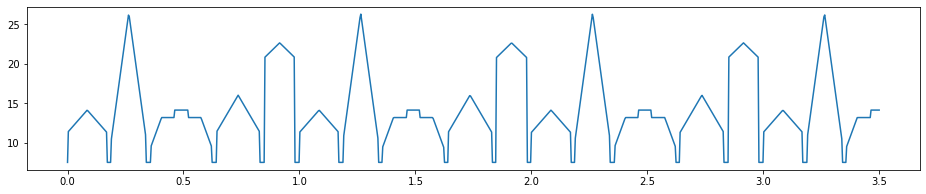

In [44]:
pts = [[0, 0.075444], [1e-07, 0.113166], [0.084874, 0.141457], [0.169748, 0.113166], 
       [0.1697481, 0.075444], [0.169748, 0.075444], [0.188609, 0.075444], [0.1886091, 0.103735],
       [0.264053, 0.264053], [0.339497, 0.103735], [0.3394971, 0.075444], [0.358358, 0.075444],
       [0.3583581, 0.094305], [0.40551, 0.132027], [0.462093, 0.132027], [0.4620931, 0.141457],
       [0.518676, 0.141457], [0.5186761, 0.132027], [0.575259, 0.132027], [0.622411, 0.094305],
       [0.6224111, 0.075444], [0.641272, 0.075444], [0.6412721, 0.113166], [0.735576, 0.160318],
       [0.829881, 0.113166], [0.8298811, 0.075444], [0.848742, 0.075444], [0.8487421, 0.20747],
       [0.914756, 0.226331], [0.980769, 0.20747], [0.9807691, 0.075444], [1.0, 0.075444]]

pre_pot = interp1d(np.array(pts)[:,0], np.array(pts)[:,1])

def potential(x):
    x = x % 1.
    return 100*pre_pot(x)

xl = np.linspace(0., 3.5, 1000)
plt.figure(figsize=(16,3))
plt.plot(xl, [potential(x) for x in xl])
plt.show()

Построим численно решения уравнения Шредингера $\psi_1^E(x)$, $\psi_2^E(x)$ с помощью функции [`odeint`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html) пакета [`scipy.integrate`](https://docs.scipy.org/doc/scipy/reference/integrate.html).
Для этого приведем стационарное уравнение Шрёдингера к системе уравнений первого порядка
$$
    \psi'(x) = \phi(x),\qquad
    \phi'(x) = \frac{2m}{\hbar^2}\bigl(V(x)-E\bigr) \, \phi(x).
$$
Координаты обезразмерим периодом $a$, а энергию &mdash; величиной $\frac{\hbar^2}{m a^2}$.

In [10]:
def schr_rhs(y, x, E, pot):
    return [y[1], 2*(pot(x) - E)*y[0]]

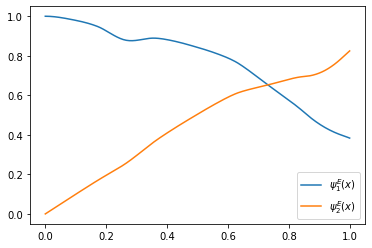

In [17]:
E = 14.5

lp = np.linspace(0., 1., 200)
y1 = odeint(schr_rhs, [1, 0], lp, args=(E, potential))
y2 = odeint(schr_rhs, [0, 1], lp, args=(E, potential))

plt.plot(lp, y1[:,0], label="$\psi_1^E(x)$")
plt.plot(lp, y2[:,0], label="$\psi_2^E(x)$")
plt.legend()
plt.show()

Далее введём функции, вычисляющие $M(a, E)$ и $\gamma(E)$
$$
    M(a, E) = 
    \begin{pmatrix}
        \psi_1^E(a) & \psi_2^E(a) \\
        {\psi_1^E}'(a) & {\psi_2^E}'(a)
    \end{pmatrix}, \qquad \gamma(E) = \frac12\operatorname{tr}M(a,E).
$$

In [18]:
def matrix_M(E, pot):
    lp = np.linspace(0., 1., 1000)
    y1 = odeint(schr_rhs, [1, 0], lp, args=(E, pot))
    y2 = odeint(schr_rhs, [0, 1], lp, args=(E, pot))

    M = np.array([y1[-1], y2[-1]])
    return M

def gamma(E, pot):
    return 0.5*matrix_M(E, pot).trace()

Так как нет зон с энергией меньше минимума потенциала, введём функцию, вычисляющую этот минимум с помощью функции [`brute`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.brute.html) пакета [`scipy.optimize`](https://docs.scipy.org/doc/scipy/reference/optimize.html).

In [19]:
def pot_min(pot):
    return pot(brute(pot, [(0., 1.)]).min())

print(pot_min(potential))

7.5443999999999996


Построим функцию $\gamma(E)$, чтобы определить местоположение зон.

In [20]:
lE = np.linspace(pot_min(potential), 80., 200)
g_data = np.array([gamma(E, potential) for E in lE])

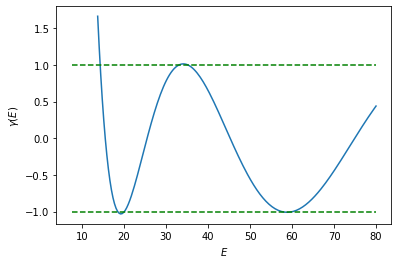

In [26]:
slc = np.abs(g_data) < 2
plt.plot(lE[slc], g_data[slc])
plt.plot([lE[0], lE[-1]], [1., 1.], c='g', ls='--')
plt.plot([lE[0], lE[-1]], [-1., -1.], c='g', ls='--')
plt.ylabel("$\gamma(E)$")
plt.xlabel("$E$")
plt.show()

# Задание

* Придумайте свой периодический потенциал (функцию `potential`). Физически аргументируйте свой выбор:)
* Напишите функцию, задающую зависимость $E = E_n(\theta)$, т.е. зависимость энергии в $n$-ой зоне от фазы собственного значения оператора трансляции $\theta$.
* Постройте на одном графике $E_n(\theta)$ нескольких первых зон для вашего потенциала, а также для потенциала свободной частицы. Поиск корней уравнений и минимумов функций рекомендую осуществлять с помощью пакета [`scipy.optimize`](https://docs.scipy.org/doc/scipy/reference/optimize.html).
* Для первой зоны постройте график периодической части $\phi_\theta(x)$ собственной функции оператора трансляции $\psi_{\theta}(x) = e^{i\theta x/a}\phi_{\theta}(x)$. Чем выделены значения $\theta = 0,\pm\pi$? Собственные векторы матрицы $M(a,E)$ удобно искать с помощью функции [`eig`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.eig.html) пакета [`scipy.linalg`](https://docs.scipy.org/doc/scipy/reference/linalg.html).